<a href="https://colab.research.google.com/github/kimberly-di-knudtson/LandsatPop/blob/main/LandsatClipping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Population Prediction from Landsat8

## Setup

In [1]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 17.5 MB/s 
     |████████████████████████████████| 6.3 MB 54.6 MB/s 
     |████████████████████████████████| 15.4 MB 28.8 MB/s 


In [2]:
!pip install geojson

In [3]:
!pip install tensorflow_io

     |████████████████████████████████| 22.7 MB 1.6 MB/s 


In [4]:
import numpy as np
import json
import geojson

import pandas as pd
import geopandas as gpd

from shapely.geometry import Polygon, MultiPolygon, box

import requests

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image
import folium

from sklearn.model_selection import train_test_split #Train-test splitting library
import tensorflow_io as tfio
import tensorflow as tf

In [5]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=ASgCaOMvxKUtMwTnlY2A12t3xSSmqQaBH16IP_3EdFQ&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWgNli36HRfQ8KyWpsErhL9G-RspMXgX-iaf2zzkfoVVWUlH8G3eRgA

Successfully saved authorization token.


In [6]:
from google.colab import drive
root_dir = '/content/gdrive/MyDrive/Colab Notebooks/'
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
from google.cloud import storage

storage_client = storage.Client.from_service_account_json("/content/gdrive/MyDrive/Colab Notebooks/teak-banner-326719-d3c2870ab6ff.json")
# Make an authenticated API request
buckets = list(storage_client.list_buckets())
print(buckets)

[<Bucket: assign8bigdata>, <Bucket: landsat_conus_tiles>]


## For mapping polygons

In [8]:
#https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-1?hl=en

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

## Constants

In [9]:
BUCKET = "landsat_conus_tiles"
KERNEL_SIZE = 224 #Size for RESNET
TRAIN_YEARS = [2015,2020] #These are the years for which both Landsat 8 and GPWv4 is available - Future improvement - use landsat7 for 2010-1013
EVAL_YEARS = [2014, 2018] #In 2020, will use different locations
PROJECTION = 'EPSG:4269' #Census geos are in this projection, Landsat is not, but is converted when the target image is obtained
BAND_SETS = ['urban', 'ir', 'cir', 'reds', 'rgb']
KERNEL_SHAPE=[KERNEL_SIZE,KERNEL_SIZE]

In [10]:
#https://www.usgs.gov/media/images/common-landsat-band-combinations
image_collection_name = "LANDSAT/LC08/C01/T1"  #Landsat8 Collection1, Tier1, #3m resolution unless otherwise noted
lsat_bands={}
lsat_bands['nearIR'] = ['B5']
lsat_bands['shortwaveIR'] = ['B6', 'B7']
lsat_bands['quality'] = ['BQA']
lsat_bands['chromatic'] = ['B8'] #15m resolution, can be used to sharpen 30m images "pan sharpening"
lsat_bands['thermalIR'] = ['B10', 'B11'] #100m resolution


lsat_bands['rgb']= ['B4', 'B3', 'B2'] #R,G,B respectively
lsat_bands['cir'] = ['B5', 'B4', 'B3'] #Color Infrared
lsat_bands['urban'] = ['B7', 'B6', 'B4'] #"Putting LSAT Bands to Work" blog
lsat_bands['ir'] = ['B11', 'B10', 'B7']
lsat_bands['reds'] = ['B11', 'B7', 'B4']


## Load CENSUS Population Estimates

In [11]:
#https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/metro/totals/
def load_census_popest(type):
  census_pop_est_files = {}
  census_pop_est_files['STATE'] = 'nst-est2020.csv'
  census_pop_est_files['CBSA'] = "cbsa-est2020.csv" #use col 'CBSA' for GEOID
  census_pop_est_files['COUNTY'] = 'co-est2020.csv'
  census_pop_est_files['CSA'] = 'csa-est2020.csv'   #This does not have a good geo column
  file = root_dir+'/Census/pop_estimates/'+census_pop_est_files[type]
  df = pd.read_csv(file,encoding='latin-1', dtype={'CBSA':str, 'MDIV':str, 'STCOU':str})
  #Limit to CONUS
  drops = ("PR","AK","HI")
  for drop in drops:
      df = df[df["NAME"].str.contains(drop) == False]

  #Get single GEOID, the pop data has nested levels CBSA, some contain one or more STCOU (county) which may contain MDIV (Metro division) geographies inside
  #So I drop the rows that have those, in favor of the CBSA's for metro/micropolitain areas
  df = df[df['MDIV'].isnull()]
  df = df[df['STCOU'].isnull()]
  df['GEOID'] = df['CBSA']  ##Note, this is a STRING
  df.set_index('GEOID', inplace=True)
  df.sort_index(inplace=True)
  return df

In [12]:
pop_df = load_census_popest('CBSA')
pop_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 919 entries, 10100 to 49820
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CBSA               919 non-null    object
 1   MDIV               0 non-null      object
 2   STCOU              0 non-null      object
 3   NAME               919 non-null    object
 4   LSAD               919 non-null    object
 5   CENSUS2010POP      919 non-null    int64 
 6   ESTIMATESBASE2010  919 non-null    int64 
 7   POPESTIMATE2010    919 non-null    int64 
 8   POPESTIMATE2011    919 non-null    int64 
 9   POPESTIMATE2012    919 non-null    int64 
 10  POPESTIMATE2013    919 non-null    int64 
 11  POPESTIMATE2014    919 non-null    int64 
 12  POPESTIMATE2015    919 non-null    int64 
 13  POPESTIMATE2016    919 non-null    int64 
 14  POPESTIMATE2017    919 non-null    int64 
 15  POPESTIMATE2018    919 non-null    int64 
 16  POPESTIMATE2019    919 non-null    int64 
 

In [13]:
pop_df.shape

(919, 19)

In [14]:
pop_df.head()

CBSA MDIV STCOU  ... POPESTIMATE2019 POPESTIMATE042020  POPESTIMATE2020
GEOID                    ...                                                   
10100  10100  NaN   NaN  ...           42740             42650            42555
10140  10140  NaN   NaN  ...           75047             75781            75950
10180  10180  NaN   NaN  ...          171949            172966           173185
10220  10220  NaN   NaN  ...           38352             38381            38397
10300  10300  NaN   NaN  ...           98519             98041            97808

[5 rows x 19 columns]

In [15]:
pop_df.describe()

CENSUS2010POP  ESTIMATESBASE2010  ...  POPESTIMATE042020  POPESTIMATE2020
count   9.190000e+02       9.190000e+02  ...       9.190000e+02     9.190000e+02
mean    3.138010e+05       3.138141e+05  ...       3.365986e+05     3.367151e+05
std     1.048272e+06       1.048279e+06  ...       1.110323e+06     1.109611e+06
min     1.353500e+04       1.353500e+04  ...       1.257900e+04     1.255200e+04
25%     4.004150e+04       4.003950e+04  ...       3.921000e+04     3.925550e+04
50%     7.279700e+04       7.280000e+04  ...       7.454300e+04     7.434700e+04
75%     1.774975e+05       1.775115e+05  ...       1.846010e+05     1.852725e+05
max     1.889711e+07       1.889628e+07  ...       1.916651e+07     1.912436e+07

[8 rows x 14 columns]

NameError: ignored

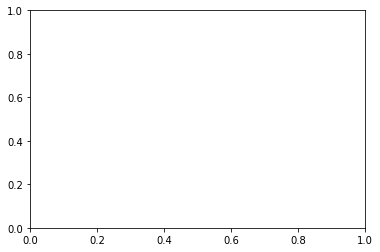

In [16]:
fig, ax = plt.subplots()
x=pop_df['CENSUS2010POP']
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
pop = ax.hist(x, bins=logbins, label = 'CENSUS2010POP')

plt.xscale('log')
ax.set_ylabel('Number geographies')
ax.set_title('Dataset Population Representation')
ax.legend()
count, _ = np.histogram(x, logbins)
print(count)
print(bins)
plt.show()

## Load CENSUS GEOGRAPHIES - CBSA Cartographic Boundary files

In [17]:
#https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.(year).html
#Metropolitan and Micropolitan Statistical Areas and Related Statistical Areas, Core Based Statistical Areas (CBSAs), 1 : 5,000,000 (national)  shapefile 
def load_census_cbsa_geo(year, type):
  path={}
  path['CB'] = 'Census/carto_bound_files/'
  path['TL'] = 'Census/tiger_line_files/'
  filename = {}
  filename['CB'] = "cb_"+str(year)+"_us_cbsa_5m.zip"
  filename['TL'] = "tl_"+str(year)+"_us_cbsa.zip"
  file = "zip://"+root_dir+path[type]+filename[type]
  gdf = gpd.read_file(file, crs='EPSG:4269')

  #Limit to CONUS
  drops = ("PR","AK","HI")
  flt_gdf = gdf.copy()
  for drop in drops:
      flt_gdf = flt_gdf[flt_gdf["NAME"].str.contains(drop) == False]
 
  #Convert to kilometers, calculate total area
  flt_gdf['ALAND'] = flt_gdf['ALAND']/1000.0
  flt_gdf['AWATER'] = flt_gdf['AWATER']/1000.0
  flt_gdf['TOTAREA'] = flt_gdf['ALAND']+flt_gdf['AWATER']
  
  #WANT GEOID to be string, all are 5 digits
  flt_gdf=flt_gdf.astype({'GEOID': str})
  return flt_gdf

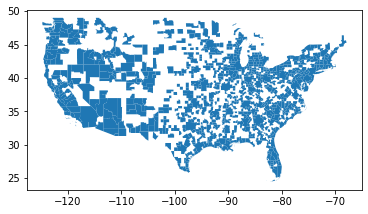

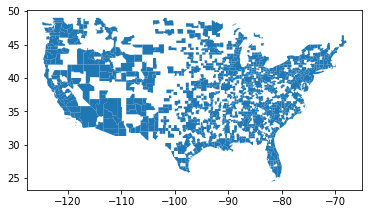

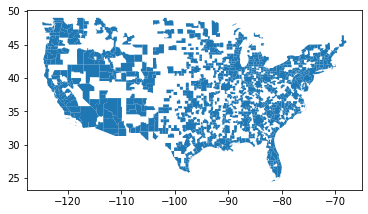

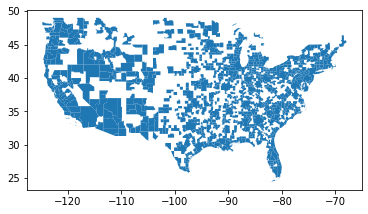

In [18]:
#LOAD
census_gdfs_by_year={}
for year in TRAIN_YEARS+EVAL_YEARS:
    census_gdfs_by_year[year] = load_census_cbsa_geo(year,'CB')
    census_gdfs_by_year[year].plot()

In [19]:
TRAIN_YEARS+EVAL_YEARS

[2015, 2020, 2014, 2018]

In [20]:
for year in census_gdfs_by_year.keys():
  print(str(year)+" - Number geos: ",census_gdfs_by_year[year].geometry.count())

2015 - Number geos:  909
2020 - Number geos:  919
2014 - Number geos:  909
2018 - Number geos:  925


###JOIN to population data on GEOID
census_gdfs_by_year

In [21]:
for year in TRAIN_YEARS+EVAL_YEARS:
  col_name='POPESTIMATE'+str(year)
  joined_gdf = census_gdfs_by_year[year].join(pop_df[col_name], on='GEOID', how='inner', rsuffix='pop')
  joined_gdf.rename(columns={col_name:'POPEST'}, inplace=True)
  #Population density based on land area
  joined_gdf['POPDENEST'] = joined_gdf['POPEST']/joined_gdf['ALAND']
  census_gdfs_by_year[year] = joined_gdf

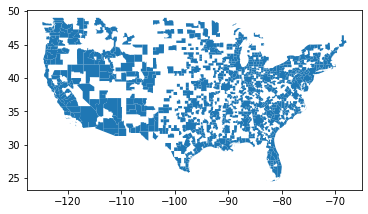

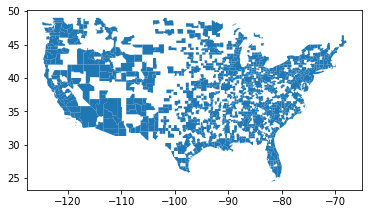

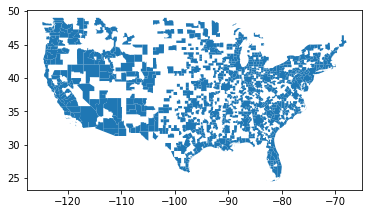

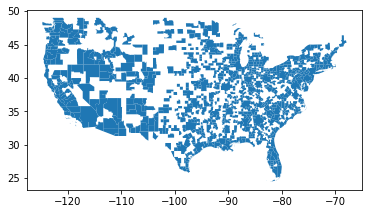

In [22]:
for year in census_gdfs_by_year.keys():
  census_gdfs_by_year[year].plot()

In [23]:
for year in census_gdfs_by_year.keys():
  print(str(year)+" - Number geos: ",census_gdfs_by_year[year].geometry.count())

2015 - Number geos:  888
2020 - Number geos:  919
2014 - Number geos:  888
2018 - Number geos:  904


## Not sure I need CENSUS POP data as a feature collection, here's a thing to make it though...

In [24]:
def getFeatureCollection(census_gdf):
  lof=[]
  count=0
  for feature in census_gdf.iterfeatures():
    props = feature.get('properties')
    #print(props)
    geom_type = feature.get('geometry').get('type')
    if ( geom_type == 'Polygon'):
      pfeat = ee.Feature(ee.Geometry.Polygon(feature.get('geometry').get('coordinates'), proj = 'EPSG:4269'),props)
    elif ( geom_type == 'MultiPolygon'):
      pfeat = ee.Feature(ee.Geometry.MultiPolygon(feature.get('geometry').get('coordinates'), proj = 'EPSG:4269'),props)
    else:
      print("Got unexpected GeometryType:", geom_type)
    lof.append(pfeat)
    count=count+1
  print("Added "+str(count)+" records to the Feature Collection")
  return ee.FeatureCollection(lof)

In [25]:
census_fc_by_year = {}
for year in census_gdfs_by_year.keys():
  census_gdf = census_gdfs_by_year[year]
  census_fc_by_year[year] = getFeatureCollection(census_gdf)

Added 888 records to the Feature Collection
Added 919 records to the Feature Collection
Added 888 records to the Feature Collection
Added 904 records to the Feature Collection


# Choropleth mapping from census_gdfs 

In [26]:
for year in census_gdfs_by_year.keys():
  print(str(year))
  print(census_gdfs_by_year[year].describe())

2015
              ALAND        AWATER       TOTAREA        POPEST   POPDENEST
count  8.880000e+02  8.880000e+02  8.880000e+02  8.880000e+02  888.000000
mean   4.662908e+06  3.265563e+05  4.989464e+06  3.351491e+05    0.061306
std    5.913002e+06  9.955994e+05  6.108547e+06  1.109747e+06    0.090102
min    2.674559e+05  2.299390e+02  2.829712e+05  1.294600e+04    0.000682
25%    1.565294e+06  1.442906e+04  1.673388e+06  4.089400e+04    0.017699
50%    2.590146e+06  4.207700e+04  2.760358e+06  7.657400e+04    0.034926
75%    5.277822e+06  1.672882e+05  5.761264e+06  1.886618e+05    0.064669
max    7.061202e+07  1.532896e+07  7.098677e+07  1.932224e+07    1.053161
2020
              ALAND        AWATER       TOTAREA        POPEST   POPDENEST
count  9.190000e+02  9.190000e+02  9.190000e+02  9.190000e+02  919.000000
mean   4.677036e+06  3.320798e+05  5.009116e+06  3.367151e+05    0.061154
std    5.892590e+06  1.032850e+06  6.094023e+06  1.109611e+06    0.092641
min    2.672930e+05  2.08105

In [27]:
pop_maps={}
for year in TRAIN_YEARS+EVAL_YEARS:
  m = folium.Map(location=[40, -99], height=500, width=700, zoom_start=4)
  dataset = census_gdfs_by_year[year]
  pop_col = "POPEST"
  bins = list(dataset[pop_col].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))
  #bins = [10000, 100000, 1000000, 10000000, 100000000]
  #use bins from pop_df analysis above
  bins = [10000, 100000, 500000, 5000000, 20000000]
  folium.Choropleth(
      geo_data=dataset.to_json(),
      name="Population Estimates - "+str(year),
      data=dataset,
      columns=["NAME", pop_col],
      fill_color="BuPu",
      fill_opacity=0.7,
      line_opacity=0.3,
      key_on="feature.properties.NAME",
      legend_name="Population",
      bins=bins,
  ).add_to(m)

  folium.LayerControl().add_to(m)
  pop_maps[year]=m


In [28]:
pop_maps

{2014: <folium.folium.Map at 0x7f8a026e3850>,
 2015: <folium.folium.Map at 0x7f8a12260210>,
 2018: <folium.folium.Map at 0x7f8a014da1d0>,
 2020: <folium.folium.Map at 0x7f8a037c1190>}

In [30]:
pop_maps[2015]

### Population Density

In [31]:
pop_den_maps={}
for year in TRAIN_YEARS+EVAL_YEARS:
  m = folium.Map(location=[40, -99], height=500, width=700, zoom_start=4)
  dataset = census_gdfs_by_year[year]
  pop_col = "POPDENEST"
  bins = [0, 0.001, 0.01, 0.1, 1, 10]
  folium.Choropleth(
      geo_data=dataset.to_json(),
      name="Population Density Estimates per sq km - "+str(year),
      data=dataset,
      columns=["NAME", pop_col],
      fill_color="OrRd",
      fill_opacity=0.7,
      line_opacity=0.3,
      key_on="feature.properties.NAME",
      legend_name="Population Density",
      bins=bins,
  ).add_to(m)

  folium.LayerControl().add_to(m)
  pop_den_maps[year]=m

In [32]:
pop_den_maps[2015]

# Landsat Data

In [33]:
def addDayNightFlag(image):
    hour = ee.Date(image.get('system:time_start')).get('hour').int()
    daynight = "NIGHT"
    #CONUS DAY IN UTC - It crosses at 10 am local on the ground
    if (hour.gt(16) and hour.lt(21)):
      daynight = "DAY"
    return image.set({'DayNight': daynight})

In [34]:
def pan_sharpen():
  #IMAGE must have RGB bands, 4-3-2 and the panchromatic band - 8

  # Convert the RGB bands to the HSV color space.
  hsv = this.select(['B4', 'B3', 'B2']).rgbToHsv()

  # Swap in the panchromatic band and convert back to RGB.
  sharpened = ee.Image.cat(
      [hsv.select('hue'),
      hsv.select('saturation'),
      this.select('B8')]).hsvToRgb()
  return sharpened

In [35]:
def getAOI(geom_type, geo_coords):
  #From and ee.Image: geom_type = image.geometry().getInfo()['type'], geo = image.geometry().getInfo()['coordinates']
  #From a GeoDataFrame: geom_type = feature.get('geometry').get('type'), geo = feature.get('geometry').get('coordinates')
  if ( geom_type == 'Polygon'):
    aoi = ee.Geometry.Polygon(geo_coords, proj = PROJECTION)
  elif ( geom_type == 'MultiPolygon'):
    mgeos = []
    for coords in range(len(geo_coords)):
      mgeos.append(ee.Geometry.Polygon(geo_coords[coords], proj = PROJECTION))
    aoi = ee.Geometry.MultiPolygon(coords=mgeos)
  return aoi

In [36]:
def getTargetImages(year, census_gdf=census_gdfs_by_year[year]):
  gdf=census_gdf
  lsat_clippings = {}
  count=0
  for feature in gdf.iterfeatures():
    props = feature.get('properties')
    geoid = str(feature.get('properties').get('GEOID'))
    pkey = str(year)+"_"+geoid
    popest = feature.get('properties').get('POPEST')
    geom_type = feature.get('geometry').get('type')
    geo = feature.get('geometry').get('coordinates')
    aoi = getAOI(geom_type,geo)
    try:
      image = ee.ImageCollection('LANDSAT/LC08/C01/T1')\
                          .filterBounds(aoi)\
                          .filterDate(str(year)+'-01-01', str(year)+'-12-31')\
                          .map(addDayNightFlag)\
                          .filter(ee.Filter.eq('DayNight','DAY'))\
                          .filter(ee.Filter.lt('CLOUD_COVER', 50))\
                          .filter(ee.Filter.gt('IMAGE_QUALITY_OLI',7))\
                          .sort('CLOUD_COVER', False)\
                          .mosaic()\
                          .clip(aoi)\
                          .set({'pkey':pkey, 'POPEST':popest})
    except EEException as msg:
      print(msg)
    else:
      lsat_clippings[pkey] = image
      count=count+1
  print ('Found '+str(count)+' target images for year '+str(year))
  return lsat_clippings

In [37]:
def getCoveringImage(year, census_gdf=census_gdfs_by_year[year]):
  coords = [*census_gdf.total_bounds]
  aoi = ee.Geometry.Rectangle(coords, proj = PROJECTION)

  try:
    composite_image = ee.ImageCollection('LANDSAT/LC08/C01/T1')\
                            .filterBounds(aoi)\
                            .filterDate(str(year)+'-01-01', str(year)+'-12-31')\
                             .map(addDayNightFlag)\
                            .filter(ee.Filter.eq('DayNight','DAY'))\
                            .filter(ee.Filter.lt('CLOUD_COVER', 50))\
                            .filter(ee.Filter.gt('IMAGE_QUALITY_OLI',7))\
                            .sort('CLOUD_COVER', False)\
                            .mosaic()\
                            .clip(aoi)
  except EEException as msg:
    print(msg)
  else:
    return composite_image

## Gridded Population of the World v4.11

In [32]:
img = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Count")\
                            .filterDate(str(year)+'-01-01', str(year)+'-12-31')

In [38]:
def getPopulationImage(year, census_gdf=census_gdfs_by_year[year]):
  if year not in TRAIN_YEARS:
    print("Grid Pop Data NOT available for year: "+str(year))
    return
  coords = [*census_gdf.total_bounds]
  aoi = ee.Geometry.Rectangle(coords, proj = PROJECTION)
  try:
    img = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Count")\
                            .filterDate(str(year)+'-01-01', str(year)+'-12-31')\
                            .first()\
                            .clip(aoi)\
                            .set({'year':year})
  except EEException as msg:
    print(msg)
  else:
    return img

### Put together 
Landsat, GridPop for Band, convert to array w/ neighborhoodToArray makes the 224x224,3 I need for ResNet

In [39]:
#https://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb#scrollTo=J1ySNup0xCqN
def getDataArrays(covering_landsat, covering_gridpop, band_set_name):
  list = ee.List.repeat(1, KERNEL_SIZE)
  lists = ee.List.repeat(list, KERNEL_SIZE)
  kernel = ee.Kernel.fixed(KERNEL_SIZE, KERNEL_SIZE, lists)

  if band_set_name not in BAND_SETS:
    print("Picked an invalid band set name: "+band_set_name+"Pick from: ",BAND_SETS)
    return
  else:
    featureStack = ee.Image.cat([
      covering_landsat.select(lsat_bands[band_set_name]),
      covering_gridpop.select('population_count')
    ]).float()

    arrays = featureStack.neighborhoodToArray(kernel)
    return arrays

## Try a sample of colorado in 2015 (17 samples), RGB Color

In [36]:
gdf = census_gdfs_by_year[2015]
co_2015_gdf = gdf[gdf['NAME'].str.contains('CO')]
sample_gdf = co_2015_gdf[['GEOID', 'NAME', 'POPEST', 'geometry']]
#sample_fc = getFeatureCollection(sample_gdf)
sample_landsat = getCoveringImage(2015, sample_gdf)
sample_landsat_poly = getTargetImages(2015, sample_gdf)
sample_gridpop = getPopulationImage(2015, sample_gdf)
sample_arrays = {}
for band_set in BAND_SETS:
  sample_arrays[band_set] = getDataArrays(sample_landsat, sample_gridpop, band_set)

Found 17 target images for year 2015


In [46]:
lsat_viz_params = {
    'bands'
    'min':0.0, 'max':30000.0
}

In [ ]:
bands = lsat_bands['rgb']
coverage_map = folium.Map(location=[40,-105], height=500, width=700, zoom_start=7)
coverage_map.add_ee_layer(sample_landsat.select(bands), lsat_viz_params,'Coverage')
display(coverage_map)

In [ ]:
gridpop_viz_params = {
  "max":1000.0,
  "palette":[
    "ffffe7",
    "86a192",
    "509791",
    "307296",
    "2c4484",
    "000066"
  ],
  "min":0.0
}
pop_map = folium.Map(location=[40,-105], height=500, width=700, zoom_start=7)
pop_map.add_ee_layer(sample_gridpop, gridpop_viz_params, 'population_count');
display(pop_map)

## Export CONUS Training Data

In [57]:
#Upload CONUS 2015 training data, 3000 records
gdf = census_gdfs_by_year[2015]
conus_gdf = gdf[['GEOID', 'NAME', 'POPEST', 'geometry']]
conus_fc = getFeatureCollection(conus_gdf)
conus_landsat = getCoveringImage(2015, conus_gdf)
conus_landsat_poly = getTargetImages(2015, conus_gdf)
conus_gridpop = getPopulationImage(2015, conus_gdf)
conus_arrays = {}
for band_set in BAND_SETS:
  conus_arrays[band_set] = getDataArrays(conus_landsat, conus_gridpop, band_set)

Added 888 records to the Feature Collection
Found 888 target images for year 2015


In [90]:
conus_arrays.keys()

dict_keys(['urban', 'ir', 'cir', 'reds', 'rgb'])

In [60]:
urban_arrays = conus_arrays['urban']

In [99]:
example = urban_arrays.sample(
  scale = 30,
  projection=PROJECTION,
  numPixels = 1
)

In [100]:
what = example.aggregate_max('B4').getInfo()
print(len(what),len(what[0]),len(what[223]))

224 224 224


One pixel sampled provides a 224x224 array per band

In [78]:
for band_set in BAND_SETS:
  for band in lsat_bands[band_set]:
    print(band_set, band, max(max(example.aggregate_max(band).getInfo())))

urban B7 8658
urban B6 8331
urban B4 24750


TypeError: ignored

In [ ]:
max(max(example.aggregate_max('B4').getInfo()))

In [71]:
what = example.aggregate_array('B4').aggregate_max('B4').getInfo()
print(len(what),len(what[0]),len(what[223]))

AttributeError: ignored

**BEWARE : 3000 tasks limit**

In [58]:
def WriteTrainingData(arrays, band_set, num_examples_per_record=32, num_records=1024):
#Error: Computed value is too large. (Error code: 3) - 500/10
  for rec in range(num_records):
    examples = arrays.sample(
      scale = 30,
      projection=PROJECTION,
      numPixels = num_examples_per_record
    )
    desc = band_set +'__rec' + str(rec)
    task = ee.batch.Export.table.toCloudStorage(
      collection = examples,
      description = desc,
      bucket = BUCKET,
      fileNamePrefix = 'Training/' + desc,
      fileFormat = 'TFRecord',
      selectors = lsat_bands[band_set] + ['population_count']
    )
    print("Starting "+desc)
    task.start()


In [126]:
BAND_SETS

['urban', 'ir', 'cir', 'reds', 'rgb']

In [59]:
band_set='rgb'
arrays = conus_arrays[band_set]
WriteTrainingData(arrays, band_set)

Starting rgb__rec0
Starting rgb__rec1
Starting rgb__rec2
Starting rgb__rec3
Starting rgb__rec4
Starting rgb__rec5
Starting rgb__rec6
Starting rgb__rec7
Starting rgb__rec8
Starting rgb__rec9
Starting rgb__rec10
Starting rgb__rec11
Starting rgb__rec12
Starting rgb__rec13
Starting rgb__rec14
Starting rgb__rec15
Starting rgb__rec16
Starting rgb__rec17
Starting rgb__rec18
Starting rgb__rec19
Starting rgb__rec20
Starting rgb__rec21
Starting rgb__rec22
Starting rgb__rec23
Starting rgb__rec24
Starting rgb__rec25
Starting rgb__rec26
Starting rgb__rec27
Starting rgb__rec28
Starting rgb__rec29
Starting rgb__rec30
Starting rgb__rec31
Starting rgb__rec32
Starting rgb__rec33
Starting rgb__rec34
Starting rgb__rec35
Starting rgb__rec36
Starting rgb__rec37
Starting rgb__rec38
Starting rgb__rec39
Starting rgb__rec40
Starting rgb__rec41
Starting rgb__rec42
Starting rgb__rec43
Starting rgb__rec44
Starting rgb__rec45
Starting rgb__rec46
Starting rgb__rec47
Starting rgb__rec48
Starting rgb__rec49
Starting r

In [61]:
band_set='reds'
arrays = conus_arrays[band_set]
WriteTrainingData(arrays, band_set)

Starting reds__rec0
Starting reds__rec1
Starting reds__rec2
Starting reds__rec3
Starting reds__rec4
Starting reds__rec5
Starting reds__rec6
Starting reds__rec7
Starting reds__rec8
Starting reds__rec9
Starting reds__rec10
Starting reds__rec11
Starting reds__rec12
Starting reds__rec13
Starting reds__rec14
Starting reds__rec15
Starting reds__rec16
Starting reds__rec17
Starting reds__rec18
Starting reds__rec19
Starting reds__rec20
Starting reds__rec21
Starting reds__rec22
Starting reds__rec23
Starting reds__rec24
Starting reds__rec25
Starting reds__rec26
Starting reds__rec27
Starting reds__rec28
Starting reds__rec29
Starting reds__rec30
Starting reds__rec31
Starting reds__rec32
Starting reds__rec33
Starting reds__rec34
Starting reds__rec35
Starting reds__rec36
Starting reds__rec37
Starting reds__rec38
Starting reds__rec39
Starting reds__rec40
Starting reds__rec41
Starting reds__rec42
Starting reds__rec43
Starting reds__rec44
Starting reds__rec45
Starting reds__rec46
Starting reds__rec47
St

EEException: ignored

# Prep and Export Eval Data

In [121]:
def doExport(image, band_set, pkey):
  """Run the image export task.  Block until complete.
  """
  desc = band_set+pkey
  task = ee.batch.Export.image.toCloudStorage(
    image = image.select(lsat_bands[band_set]),
    description = desc,
    bucket = BUCKET,
    fileNamePrefix = 'Test' + '/' + desc,
    region = getAOI(image.geometry().getInfo()['type'], image.geometry().getInfo()['coordinates']),
    scale = 30,
    fileFormat = 'TFRecord',
    maxPixels = 1e10,
    formatOptions = {
      'patchDimensions': KERNEL_SHAPE,
      'kernelSize': [112, 112],
      'compressed': True,
      'maxFileSize': 104857600
    }
  )
  task.start()

In [117]:
conus_landsat_poly.keys()

dict_keys(['2015_22300', '2015_12260', '2015_29860', '2015_14460', '2015_40660', '2015_28940', '2015_12580', '2015_14260', '2015_45500', '2015_25700', '2015_21840', '2015_49380', '2015_11700', '2015_32700', '2015_25580', '2015_18020', '2015_13340', '2015_36260', '2015_30900', '2015_24340', '2015_15340', '2015_19940', '2015_19860', '2015_39820', '2015_35220', '2015_37660', '2015_12780', '2015_30060', '2015_44620', '2015_43760', '2015_44740', '2015_18100', '2015_29940', '2015_21140', '2015_35820', '2015_29500', '2015_35420', '2015_13700', '2015_11540', '2015_16220', '2015_40620', '2015_24420', '2015_11220', '2015_40300', '2015_15220', '2015_22780', '2015_34660', '2015_45520', '2015_41460', '2015_43660', '2015_33420', '2015_46620', '2015_26460', '2015_17700', '2015_20340', '2015_12460', '2015_32740', '2015_25780', '2015_10860', '2015_10300', '2015_26980', '2015_18180', '2015_22260', '2015_11180', '2015_48140', '2015_15620', '2015_34220', '2015_37740', '2015_22420', '2015_41660', '2015_129

In [122]:
for pkey in conus_landsat_poly.keys():
  image=conus_landsat_poly[pkey]
  for band_set in ['urban', 'ir', 'cir']:
    doExport(image, band_set, pkey)